In [1]:
import os
import random 
from glob import glob 
import numpy as np 
import matplotlib.pyplot as plt 
from tqdm.notebook import tqdm 
import json
import pandas as pd
from scipy.stats import norm

from poreUtils import *


In [2]:
# Directory where the scans are stored with results 
root_dir = 'D:\sagar\Data'

In [3]:
# Getting the scans where pypore3d analysis has been run 
scans = []
for p in os.listdir(root_dir):
    file_path = os.path.join(root_dir, p, 'porespy')
    if os.path.exists(file_path):
        scans.append(p)

In [4]:
# geting the group information
df = pd.read_csv('study_group.csv')
df

,Identification,Group,ImgBL,ImgVILI,Sample,Scan
0,Rat1,Con-VILI,1,1,MD_1264_A1,MD_1264_A1_1_Z0.0mm
1,Rat1,Con-VILI,1,1,MD_1264_A1,MD_1264_A1_1_Z3.3mm
2,Rat1,Con-VILI,1,1,MD_1264_A1,MD_1264_A1_1_Z6.6mm
3,Rat1,Con-VILI,1,1,MD_1264_A1,MD_1264_A1_1_Z9.9mm
4,Rat1,Con-VILI,1,1,MD_1264_A1,MD_1264_A1_1_Z13.2mm
...,...,...,...,...,...,...
72,Rat9,Ble-VILI,1,1,MD_1264_B9,MD_1264_B9_Z0.0mm
73,Rat9,Ble-VILI,1,1,MD_1264_B9,MD_1264_B9_Z3.3mm
74,Rat9,Ble-VILI,1,1,MD_1264_B9,MD_1264_B9_Z6.6mm
75,Rat10,Con-VILI,1,1,MD_1264_B10,MD_1264_B10_Z0.0mm


In [5]:
# creating diffrent groupsfrom the available scans
scan_groups = {}
for g in np.unique(df['Group']):
    scan_groups[g] = []

for scan in scans:
    scan_index = df.loc[df['Scan'] == str(scan)].index[0]
    group = df['Group'][scan_index]
    scan_groups[group].append(scan)

print(scan_groups)

{'Ble': ['MD_1264_A11_Z3.3mm_corr_phrt', 'MD_1264_A18', 'MD_1264_A3_1_Z0.0mm', 'MD_1264_A3_1_Z3.3mm', 'MD_1264_A3_1_Z6.6mm', 'MD_1264_A3_1_Z9.9mm', 'MD_1264_A6_1_Z3.3mm_corr_phrt', 'MD_1264_B3_1_Z3.3mm'], 'Ble-VILI': ['MD_1264_A12_Z3.3mm_corr_phrt', 'MD_1264_A2_1_Z3.3mm', 'MD_1264_A5_1_Z0.0mm_corr_phrt', 'MD_1264_A8_1_Z3.3mm_corr_phrt', 'MD_1264_A9_Z0.0mm_Z3.3mm', 'MD_1264_B2_1', 'MD_1264_B5_1_Z3.3mm', 'MD_1264_B9_Z3.3mm'], 'Con-VILI': ['MD_1264_A10_Z6.6mm', 'MD_1264_A13_1_Z3.3mm_corr_phrt', 'MD_1264_A16_Z3.3mm_corr_phrt', 'MD_1264_A1_1_Z3.3mm', 'MD_1264_A4_1_Z0.0mm_Z0.0mm_corr_phrt', 'MD_1264_A4_1_Z0.0mm_Z3.3mm_corr_phrt', 'MD_1264_A4_1_Z0.0mm_Z6.6mm_corr_phrt', 'MD_1264_B10_Z3.3mm', 'MD_1264_B4_1_Z3.3mm']}


In [7]:
def ratio_greater_than_threshold(lst, threshold, start=None, end=None):
    """
    Calculate the ratio of values in a list that are greater than a specified threshold.

    Args:
        lst (list): The list of numbers.
        threshold (float): The threshold value to compare each element against.
        start (float): The starting value of the range to consider. Defaults to None, which means
                       start at the beginning of the list.
        end (float): The ending value of the range to consider. Defaults to None, which means
                     end at the end of the list.

    Returns:
        float: The ratio of values in the specified range of the list that are greater than the threshold.
    """
    if start is None:
        start = lst[0]
    if end is None:
        end = lst[-1]

    start_index = lst.index(start) if start in lst else None
    end_index = lst.index(end) if end in lst else None

    if start_index is None:
        start_index = 0
    if end_index is None:
        end_index = len(lst)

    count_greater = sum(1 for x in lst[start_index:end_index] if x > threshold)
    count_total = end_index - start_index

    return count_greater / count_total if count_total > 0 else 0.0



In [10]:
def data_distribution_plots(scan_group_dict, scan_rootPath, scan_regx, feature):
    parameter_per_group = []
    for key in scan_group_dict.keys():
        json_files = []
        for aFile in scan_group_dict[key]:
            fpath = os.path.join(scan_rootPath, aFile, 'porespy')
            json_files += glob(fpath + '\*' +scan_regx + '.json')
        
        parameter = []
        for json_file in json_files:
            file = open(json_file)
            data = json.load(file)
            file.close()
            extract_feature = data[feature]

            #
            # do what we want to plot for exampe, blob volume
            #
            # property_to_append = len(extract_feature) # Number of blobs 

            # parameter += extract_feature  
            if len(extract_feature) > 0:
                parameter.append(ratio_greater_than_threshold(extract_feature, 100000))
            


        parameter_per_group.append([key, parameter])    

    # Create a figure and axis object
    fig, ax = plt.subplots()

    # Create the boxplot
    ax.boxplot([x[1] for x in parameter_per_group])

    # Add labels and a title to the plot
    ax.set_xlabel('study Groups', size=15)
    ax.set_ylabel('data distribution', size=15)
    ax.set_title(('boxplot of ' + feature + ' with ' + scan_regx), size=15)
    ax.set_xticklabels([x[0] for x in parameter_per_group])
    ax.tick_params(axis='both', which='major', labelsize=15)

    # Display the plot
    plt.show()


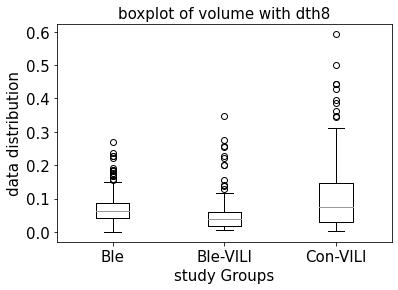

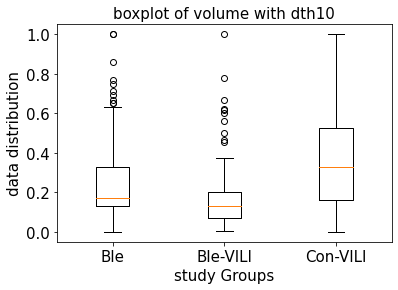

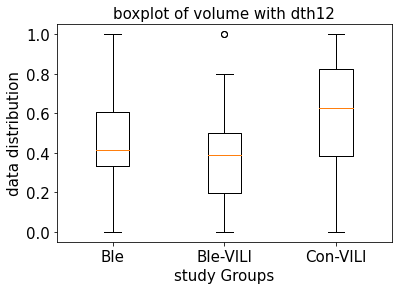

In [11]:
seed_threshold = ['dth8', 'dth10', 'dth12']
for seed in seed_threshold:
    data_distribution_plots(scan_groups, root_dir, seed, 'volume')

In [12]:
def data_distribution_plots_per_seed(list_of_seed, scan_group_dict, scan_rootPath, feature):
    parameter_per_group_per_seed = []
    for seed in list_of_seed:
        parameter_per_group = []
        for key in scan_group_dict.keys():
            json_files = []
            for aFile in scan_group_dict[key]:
                fpath = os.path.join(scan_rootPath, aFile, 'porespy')
                json_files += glob(fpath + '\*' + seed + '.json')
            
            parameter = []
            for json_file in json_files:
                file = open(json_file)
                data = json.load(file)
                file.close()
                extract_feature = data[feature]

                #
                # do what we want to plot for exampe, blob volume
                #
                # property_to_append = len(extract_feature) # Number of blobs 
                # parameter += extract_feature
                if len(extract_feature) > 0:
                    parameter.append(ratio_greater_than_threshold(extract_feature, 100000))
            
            parameter_per_group.append([key, parameter])
        
        parameter_per_group_per_seed.append([seed, parameter_per_group])


    # Create a figure and axis object
    fig, ax = plt.subplots(figsize=(16,9))    
    xticks = []
    xticklabels = []   
    for i, aSeedData in enumerate(parameter_per_group_per_seed):

        for j, gr_of_seed in enumerate(aSeedData[1]):
            grp = gr_of_seed[0]
            data = gr_of_seed[1]
            ax.boxplot(data, positions=[i+j*4], widths=0.6)
            
            xticks.append(i+j*4)
            if aSeedData[0] == 'dth10':
                xticklabels.append(aSeedData[0]+ '\n' + grp)
            else:
                xticklabels.append(aSeedData[0])



            
    ax.set_xticklabels(xticklabels)
    ax.set_xticks(xticks)
    ax.tick_params(axis='both', which='major', labelsize=20)


    plt.show()

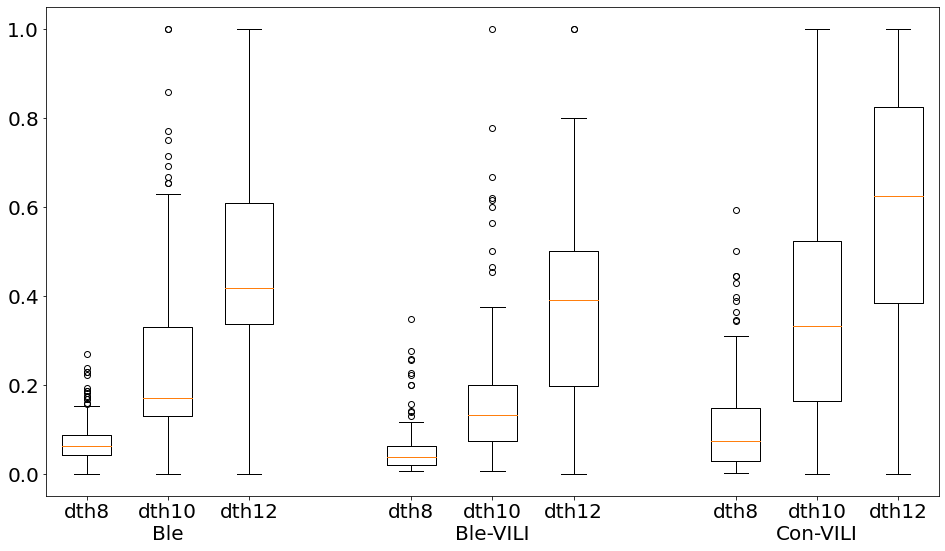

In [13]:
seed_threshold = ['dth8', 'dth10', 'dth12']
data_distribution_plots_per_seed(seed_threshold, scan_groups, root_dir, 'volume')

In [14]:
def data_distribution_plots_per_seed2(list_of_seed, scan_group_dict, scan_rootPath, feature):
    parameter_per_group_per_seed = []
    for seed in list_of_seed:
        parameter_per_group = []
        for key in scan_group_dict.keys():
            json_files = []
            for aFile in scan_group_dict[key]:
                fpath = os.path.join(scan_rootPath, aFile, 'porespy')
                json_files += glob(fpath + '\*' + seed + '.json')
            
            parameter = []
            for json_file in json_files:
                file = open(json_file)
                data = json.load(file)
                file.close()
                extract_feature = data[feature]

                #
                # do what we want to plot for exampe, blob volume
                #
                # property_to_append = len(extract_feature) # Number of blobs 
                # parameter += extract_feature
                if len(extract_feature) > 0:
                    parameter.append(ratio_greater_than_threshold(extract_feature, 100000))
            
            parameter_per_group.append([key, parameter])
        
        parameter_per_group_per_seed.append([seed, parameter_per_group])


    # Create a figure and axis object
    fig, ax = plt.subplots(figsize=(16,9))    
    xticks = []
    xticklabels = []   
    for i, aSeedData in enumerate(parameter_per_group_per_seed):

        for j, gr_of_seed in enumerate(aSeedData[1]):
            grp = gr_of_seed[0]
            data = gr_of_seed[1]
            ax.boxplot(data, positions=[i*4+j], widths=0.6)
            
            xticks.append(i*4+j)
            if grp == 'Ble-VILI':
                xticklabels.append(grp+'\n'+aSeedData[0])
        
            else:
                xticklabels.append(grp)



            
    ax.set_xticklabels(xticklabels)
    ax.set_xticks(xticks)
    ax.tick_params(axis='both', which='major', labelsize=20)


    plt.show()

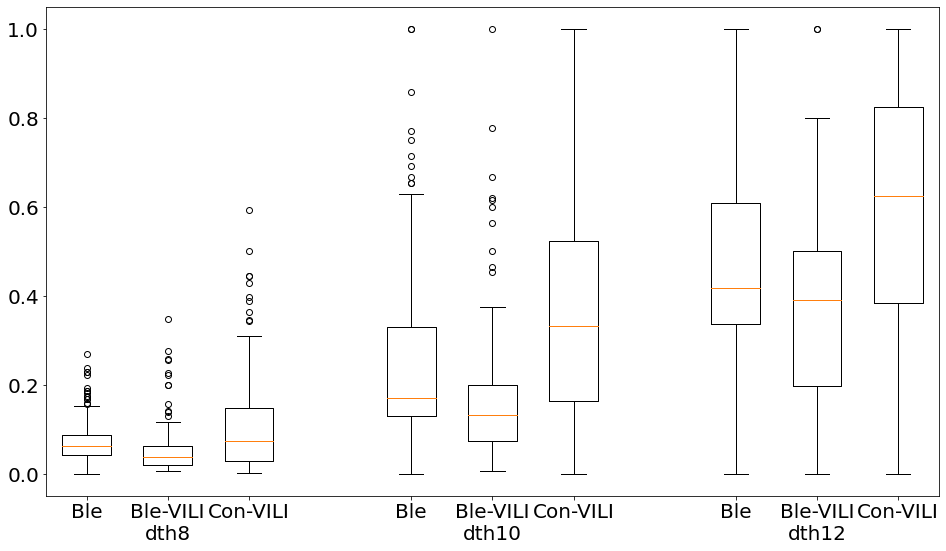

In [15]:
seed_threshold = ['dth8', 'dth10', 'dth12']
data_distribution_plots_per_seed2(seed_threshold, scan_groups, root_dir, 'volume')

In [ ]:
# box plot suggestion from Lorenzo 
# statanotations.Anotator

### Box plot distribution of volume with some thresholding to remove small volumes and with annotation for better understanding 

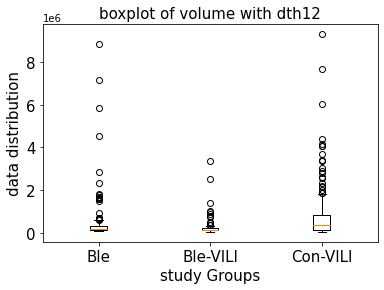

In [117]:
parameter_per_group = []
for key in scan_groups.keys():
    json_files = []
    for aFile in scan_groups[key]:
        fpath = os.path.join(root_dir, aFile, 'porespy')
        json_files += glob(fpath + '\*' + 'dth12' + '.json')

    parameter = []
    for json_file in json_files:
        file = open(json_file)
        data = json.load(file)
        file.close()
        extract_feature = data['volume']

        #
        # do what we want to plot for exampe, blob volume
        #
        if len(extract_feature) > 0:
            # parameter += extract_feature
            parameter.append(np.mean(extract_feature))

    parameter_per_group.append([key, parameter]) 

# Create a figure and axis object
fig, ax = plt.subplots()

for i, agrp in enumerate(parameter_per_group):
    # print(len(agrp[1]))
    # print(len([x for x in agrp[1] if x < 1000]))



    # Create the boxplot
    ax.boxplot([x for x in agrp[1] if x > 1000], positions=[i])

# Add labels and a title to the plot
ax.set_xlabel('study Groups', size=15)
ax.set_ylabel('data distribution', size=15)
ax.set_title(('boxplot of ' + 'volume' + ' with ' + 'dth12'), size=15)
ax.set_xticklabels([x[0] for x in parameter_per_group])
ax.tick_params(axis='both', which='major', labelsize=15)

# Display the plot
plt.show()

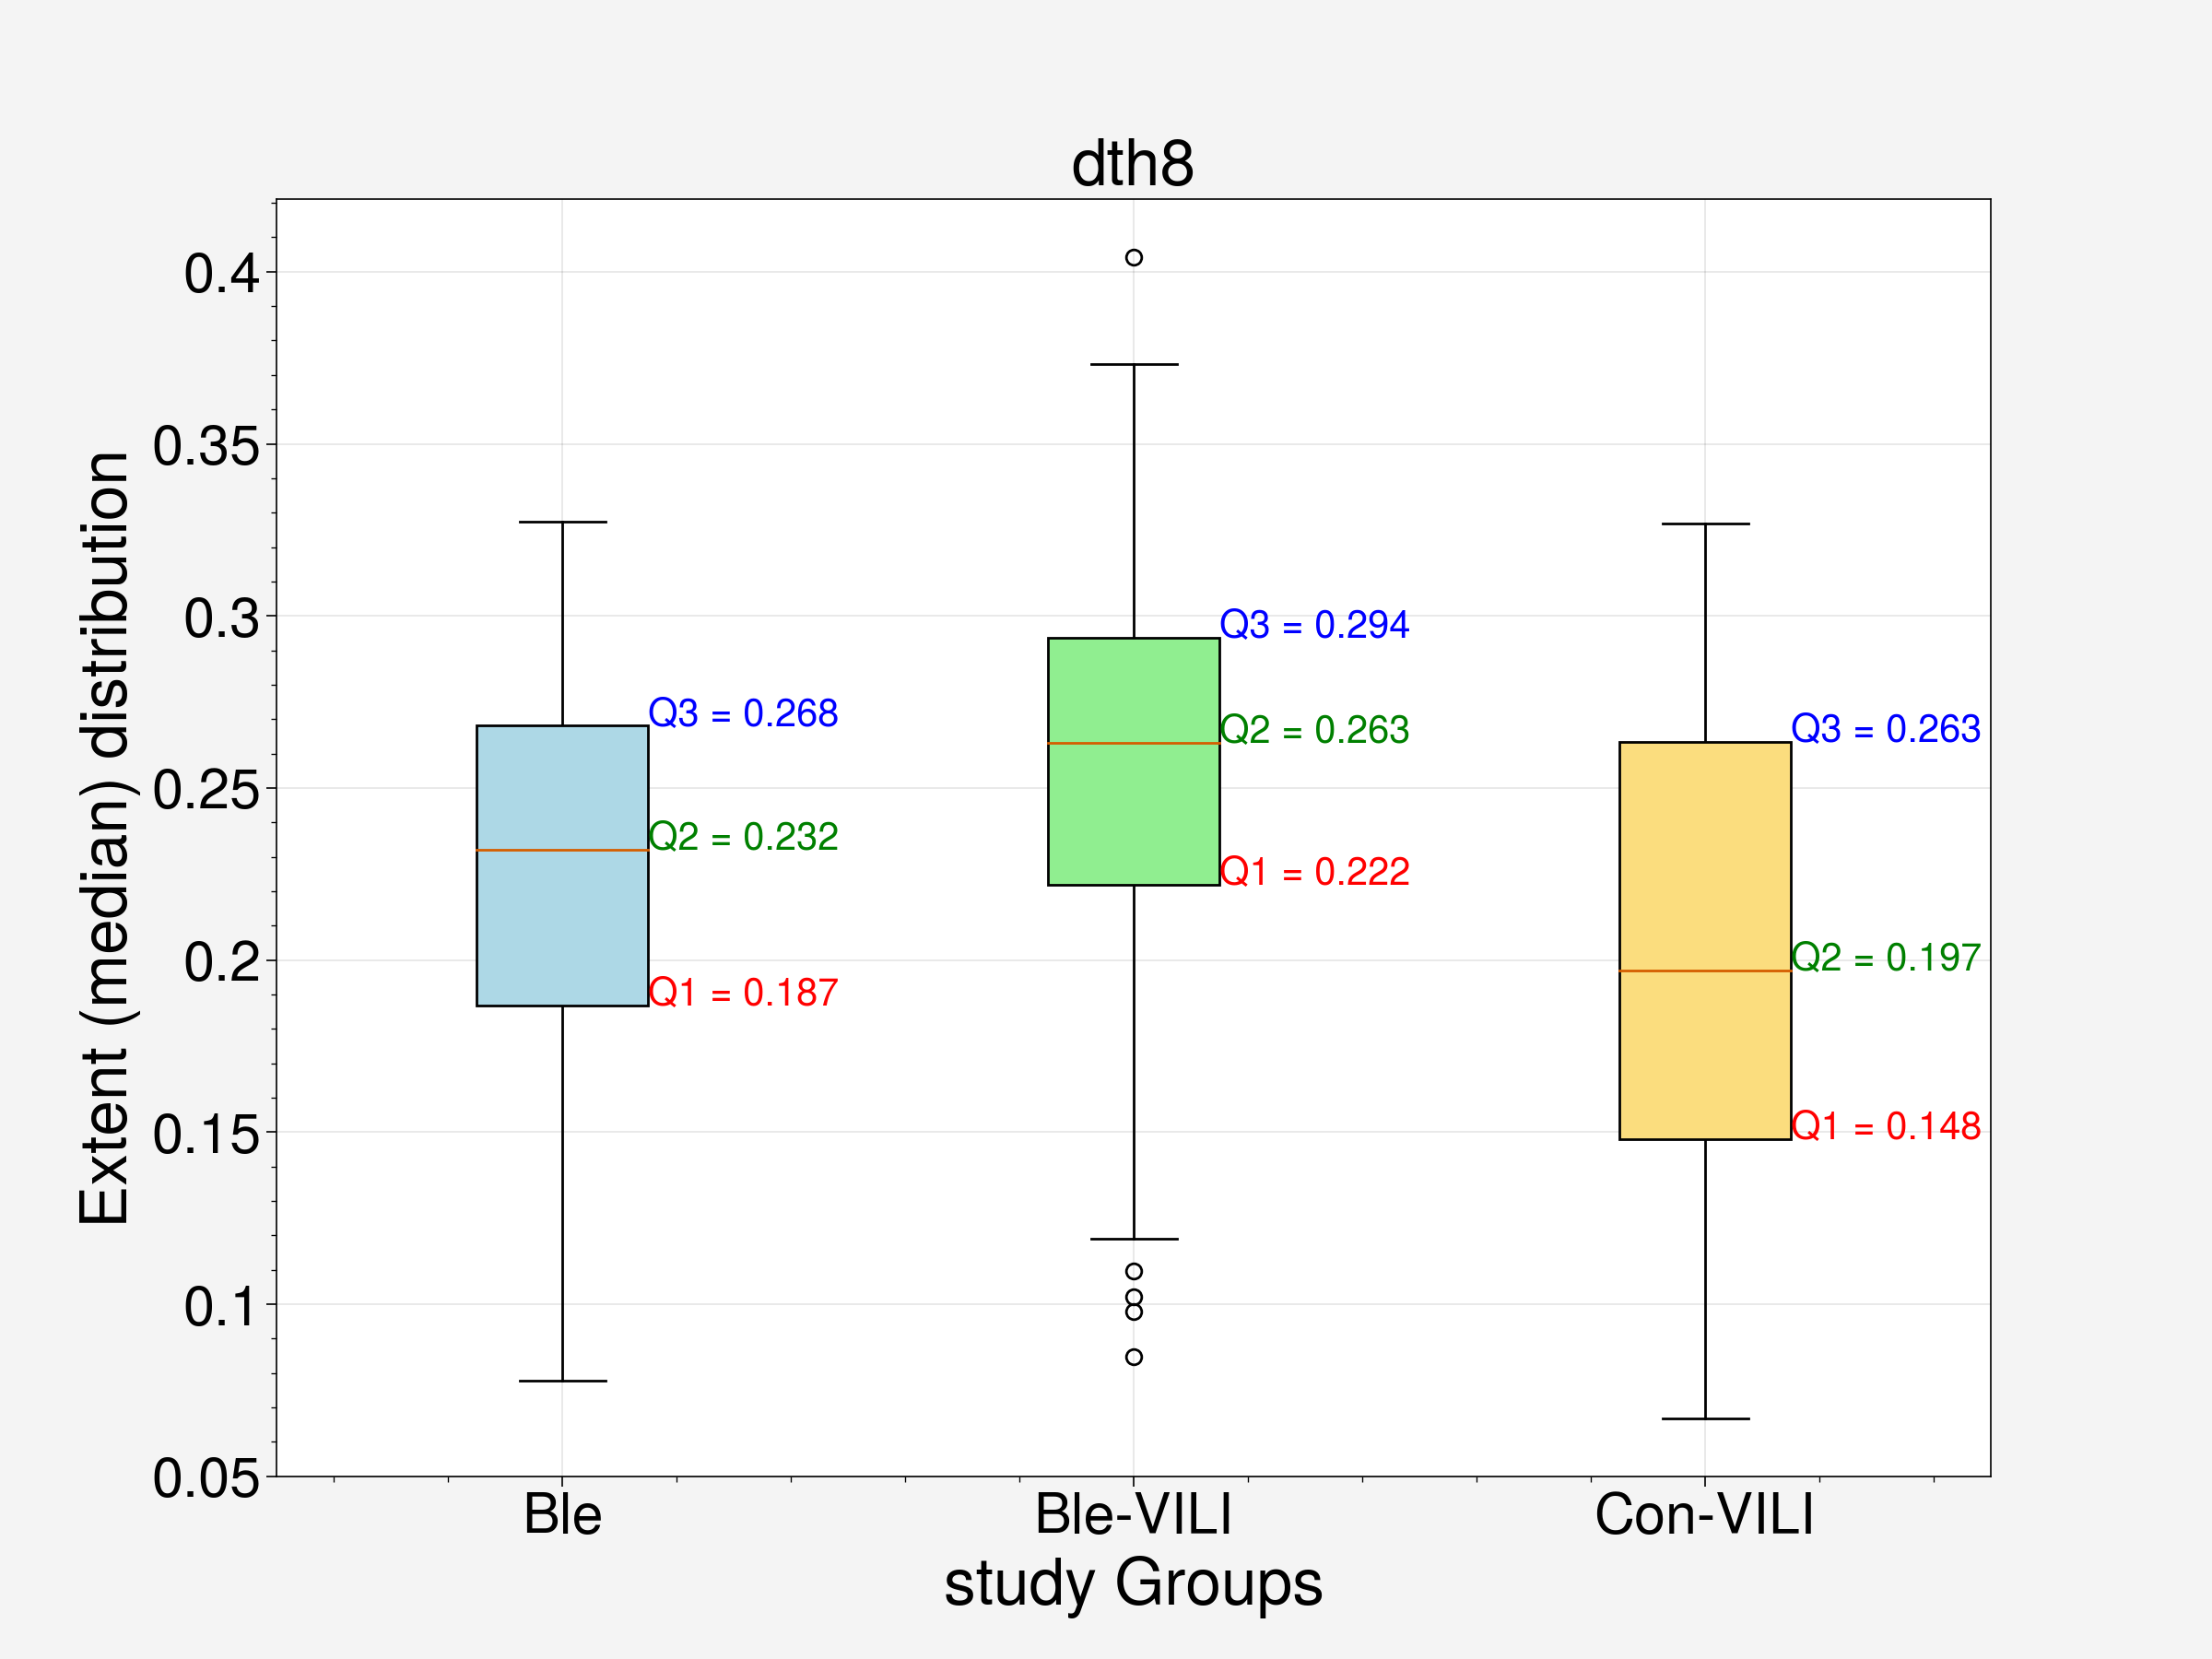

In [209]:
parameter_per_group = []
for key in scan_groups.keys():
    json_files = []
    for aFile in scan_groups[key]:
        fpath = os.path.join(root_dir, aFile, 'porespy')
        json_files += glob(fpath + '\*' + 'dth8' + '.json')

    parameter = []
    for json_file in json_files:
        file = open(json_file)
        data = json.load(file)
        file.close()
        extract_feature = data['extent']

        #
        # do what we want to plot for exampe, blob volume
        #
        if len(extract_feature) > 0:
            # parameter += extract_feature
            parameter.append(np.median(extract_feature))
            # parameter.append(ratio_greater_than_threshold(extract_feature, 1000000))

    parameter_per_group.append([key, parameter]) 

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(12,9))

# Create the boxplot
bp = ax.boxplot([x[1] for x in parameter_per_group], patch_artist=True, boxprops=dict(facecolor='lightgray', edgecolor='black'))

# Add color to the boxes
colors = ['lightblue', 'lightgreen', 'wheat', 'plum']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# Loop through the boxes and add the quartile values as text
for i, box in enumerate(bp['boxes']):
    # Calculate the quartiles
    q1, q2, q3 = np.percentile([x[1] for x in parameter_per_group][i], [25, 50, 75])
    

    # Add text labels for the quartile values
    ax.text(i+1.15, q1, f'Q1 = {q1:.3f}', color='r', fontsize=15)
    ax.text(i+1.15, q2, f'Q2 = {q2:.3f}', color='g', fontsize=15)
    ax.text(i+1.15, q3, f'Q3 = {q3:.3f}', color='b', fontsize=15)

# Add labels and a title to the plot
ax.set_xlabel('study Groups', size=25)
ax.set_ylabel('Extent (median) distribution', size=25)
ax.set_title(('dth8'), size=25)
ax.set_xticklabels([x[0] for x in parameter_per_group])
ax.tick_params(axis='both', which='major', labelsize=22)
# ax.set_ylim([0, 1.3e5])
# ax.set_xlim([0, 4])

plt.savefig('Output/median_extent_dth8.svg', facecolor='whitesmoke')

# Display the plot
plt.show()

### PyPore3D

In [94]:
# Getting the scans where pypore3d analysis has been run 
scans = []
for p in os.listdir(root_dir):
    file_path = os.path.join(root_dir, p, 'result')
    if os.path.exists(file_path):
        scans.append(p)

In [97]:
# creating diffrent groupsfrom the available scans
scan_groups = {}
for g in np.unique(df['Group']):
    scan_groups[g] = []

for scan in scans:
    scan_index = df.loc[df['Scan'] == str(scan)].index[0]
    group = df['Group'][scan_index]
    scan_groups[group].append(scan)

print(scan_groups)

{'Ble': ['MD_1264_A11_Z3.3mm_corr_phrt', 'MD_1264_A18', 'MD_1264_A3_1_Z0.0mm', 'MD_1264_A3_1_Z3.3mm', 'MD_1264_A3_1_Z6.6mm', 'MD_1264_A3_1_Z9.9mm', 'MD_1264_A6_1_Z3.3mm_corr_phrt', 'MD_1264_B3_1_Z3.3mm'], 'Ble-VILI': ['MD_1264_A12_Z3.3mm_corr_phrt', 'MD_1264_A2_1_Z3.3mm', 'MD_1264_A5_1_Z0.0mm_corr_phrt', 'MD_1264_A8_1_Z3.3mm_corr_phrt', 'MD_1264_A9_Z0.0mm_Z3.3mm', 'MD_1264_B2_1', 'MD_1264_B5_1_Z3.3mm', 'MD_1264_B9_Z3.3mm'], 'Con-VILI': ['MD_1264_A10_Z6.6mm', 'MD_1264_A13_1_Z3.3mm_corr_phrt', 'MD_1264_A16_Z3.3mm_corr_phrt', 'MD_1264_A1_1_Z3.3mm', 'MD_1264_A4_1_Z0.0mm_Z0.0mm_corr_phrt', 'MD_1264_A4_1_Z0.0mm_Z3.3mm_corr_phrt', 'MD_1264_A4_1_Z0.0mm_Z6.6mm_corr_phrt', 'MD_1264_B10_Z3.3mm', 'MD_1264_B4_1_Z3.3mm']}


In [99]:
for key in scan_groups.keys():
    json_files = []
    for aFile in scan_groups[key]:
        fpath = os.path.join(root_dir, aFile, 'result')
        json_files += glob(fpath + '\*.json')

    parameter = []
    for json_file in json_files[0:1]:
        file = open(json_file)
        data = json.load(file)
        file.close()
        extract_feature = data['blob_analysis']['result']['VOLUME']

print(extract_feature)

[0.09768, 5.6000000000000005e-08, 2.368e-06, 1.28e-07, 7.200000000000001e-08, 6.168e-06, 1.9200000000000003e-07, 1.6e-08, 2.632e-06, 1.4400000000000002e-07, 7.200000000000001e-08, 2.2e-06, 7.680000000000001e-06, 3.1376e-05, 1.04e-07, 1.6e-08, 4.8000000000000006e-08, 8e-08, 3.2e-08, 1.776e-06, 6.472e-06, 8e-08, 1.016e-06, 4.16e-07, 1.2944e-05, 1.6800000000000002e-07, 3.2e-08, 3.2e-08, 6.960000000000001e-07, 1.36e-07, 2.464e-06, 8.041600000000001e-05, 8e-09, 8e-09, 4.8000000000000006e-08, 4.7200000000000005e-06, 9.744e-06, 1.6960000000000002e-06, 1.7600000000000001e-07, 4.016e-06, 7.824e-06, 1.1200000000000001e-07, 9.600000000000001e-08, 9.520000000000001e-07, 3.004e-05, 8e-09, 3.268e-05, 8e-09, 7.680000000000001e-06, 3.2e-08, 3.2e-08, 8e-09, 1.4272000000000002e-05, 7.200000000000001e-08, 3.2e-08, 1.9200000000000003e-07, 2.72e-07, 8e-09, 8e-09, 3.2e-08, 2.08e-07, 8e-08, 1.84e-07, 1.6e-08, 8e-09, 1.1200000000000001e-07, 4.504e-06, 7.0368e-05, 4.56e-07, 3.2e-08, 3.2e-08, 1.1216e-05, 4e-08,

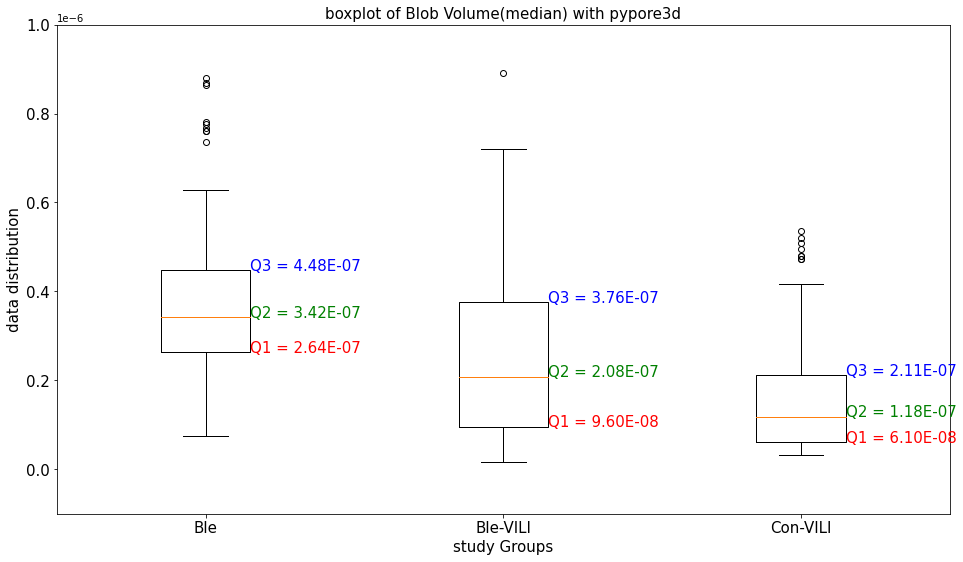

In [114]:
parameter_per_group = []
for key in scan_groups.keys():
    json_files = []
    for aFile in scan_groups[key]:
        fpath = os.path.join(root_dir, aFile, 'result')
        json_files += glob(fpath + '\*.json')

    parameter = []
    for json_file in json_files:
        file = open(json_file)
        data = json.load(file)
        file.close()
        extract_feature = data['blob_analysis']['result']['VOLUME']

        #
        # do what we want to plot for exampe, blob volume
        #
        if len(extract_feature) > 0:
            # parameter += extract_feature
            parameter.append(np.median(extract_feature))
            # parameter.append(ratio_greater_than_threshold(extract_feature, 1000000))

    parameter_per_group.append([key, parameter]) 

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(16,9))

# Create the boxplot
bp = ax.boxplot([x[1] for x in parameter_per_group])

# Loop through the boxes and add the quartile values as text
for i, box in enumerate(bp['boxes']):
    # Calculate the quartiles
    q1, q2, q3 = np.percentile([x[1] for x in parameter_per_group][i], [25, 50, 75])
    

    # Add text labels for the quartile values
    ax.text(i+1.15, q1, f'Q1 = {q1:.2E}', color='r', fontsize=15)
    ax.text(i+1.15, q2, f'Q2 = {q2:.2E}', color='g', fontsize=15)
    ax.text(i+1.15, q3, f'Q3 = {q3:.2E}', color='b', fontsize=15)

# Add labels and a title to the plot
ax.set_xlabel('study Groups', size=15)
ax.set_ylabel('data distribution', size=15)
ax.set_title(('boxplot of Blob Volume(median)' + ' with ' + 'pypore3d'), size=15)
ax.set_xticklabels([x[0] for x in parameter_per_group])
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_ylim([-0.0000001, 0.000001])

# Display the plot
plt.show()

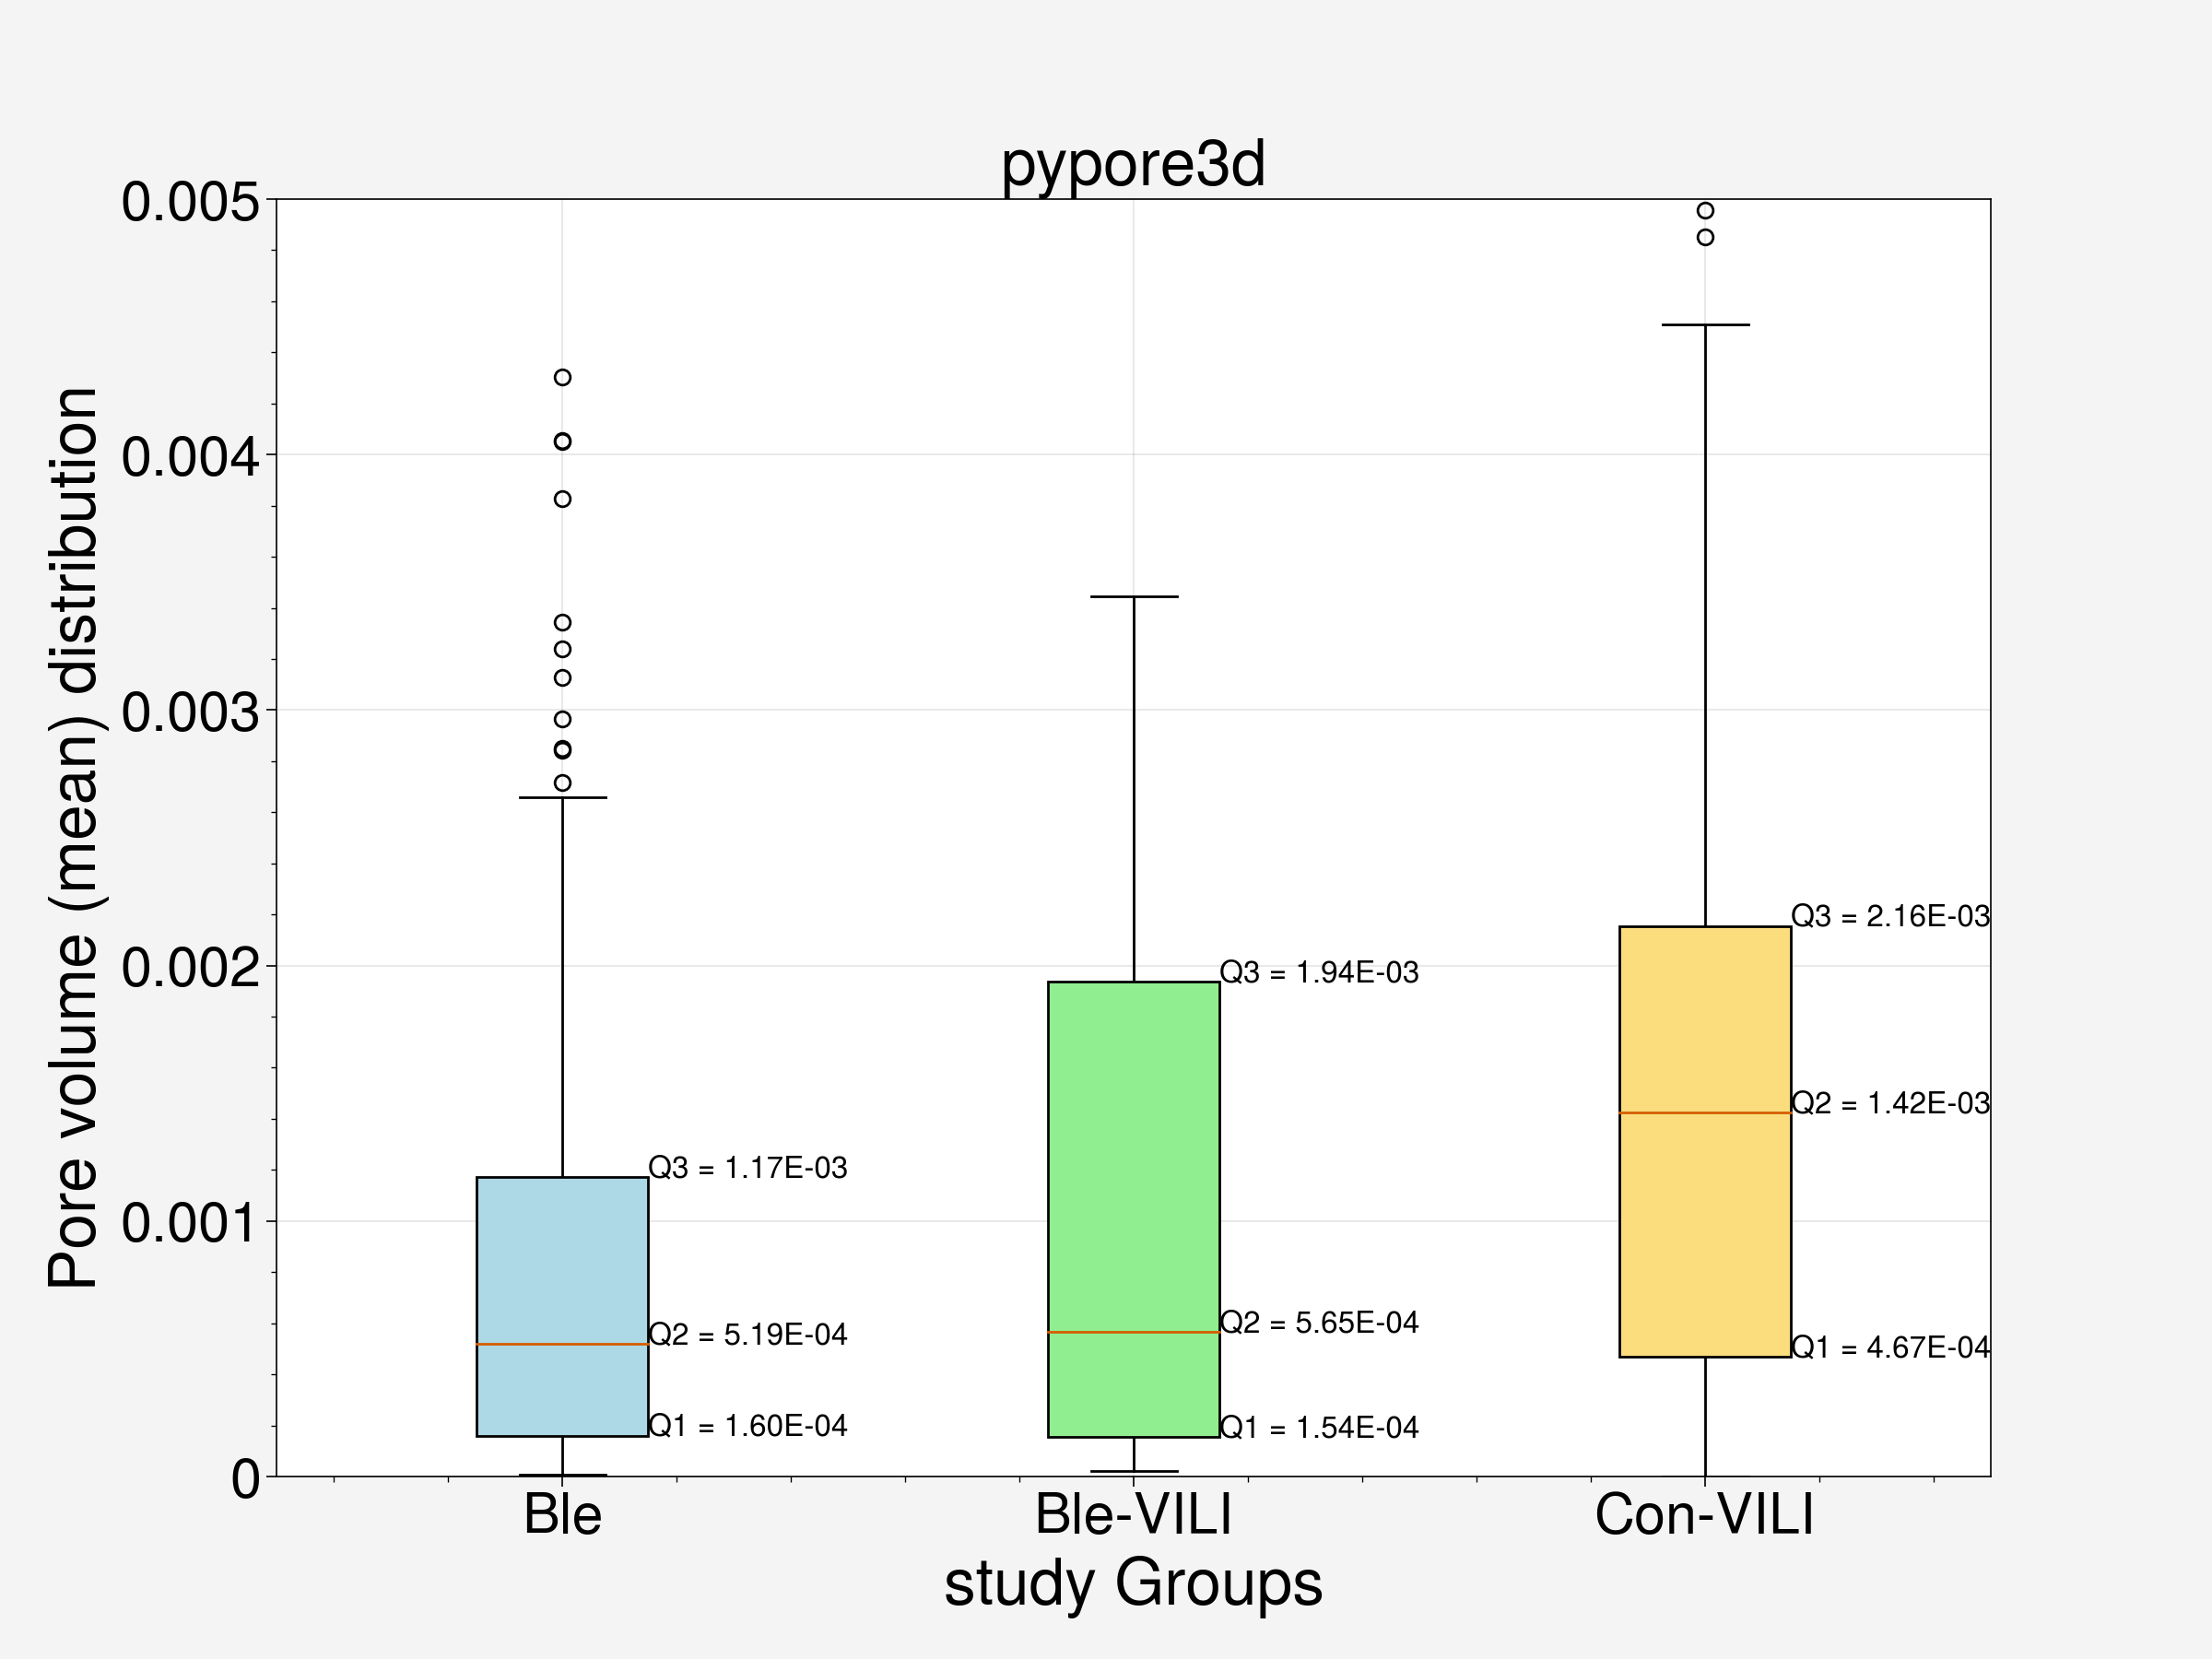

In [225]:
# Extract the parameters from the JSON files for each group
parameter_per_group = []
for key in scan_groups.keys():
    json_files = []
    for aFile in scan_groups[key]:
        fpath = os.path.join(root_dir, aFile, 'result')
        json_files += glob(fpath + '\*.json')

    parameter = []
    for json_file in json_files:
        with open(json_file) as file:
            data = json.load(file)
        extract_feature = data['blob_analysis']['result']['VOLUME']

        if len(extract_feature) > 0:
            parameter.append(np.mean(extract_feature))

    parameter_per_group.append([key, parameter]) 

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(12,9))

# Create the boxplot
bp = ax.boxplot([x[1] for x in parameter_per_group], patch_artist=True, boxprops=dict(facecolor='lightgray', edgecolor='black'))

# Add color to the boxes
colors = ['lightblue', 'lightgreen', 'wheat', 'plum']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# Loop through the boxes and add the quartile values as text
for i, box in enumerate(bp['boxes']):
    # Calculate the quartiles
    q1, q2, q3 = np.percentile([x[1] for x in parameter_per_group][i], [25, 50, 75])
    
    # Add text labels for the quartile values
    ax.text(i+1.15, q1, f'Q1 = {q1:.2E}', color='black', fontsize=12)
    ax.text(i+1.15, q2, f'Q2 = {q2:.2E}', color='black', fontsize=12)
    ax.text(i+1.15, q3, f'Q3 = {q3:.2E}', color='black', fontsize=12)

# Add labels and a title to the plot
ax.set_xlabel('study Groups', size=25)
ax.set_ylabel('Pore volume (mean) distribution', size=25)
ax.set_title(('pypore3d'), size=25)
ax.set_xticklabels([x[0] for x in parameter_per_group])
ax.tick_params(axis='both', which='major', labelsize=22)
ax.set_ylim([0, 0.005])
# ax.set_xlim([0, 4])

plt.savefig('Output/mean_vol_pypore3d.svg', facecolor='whitesmoke')

# Display the plot
plt.show()

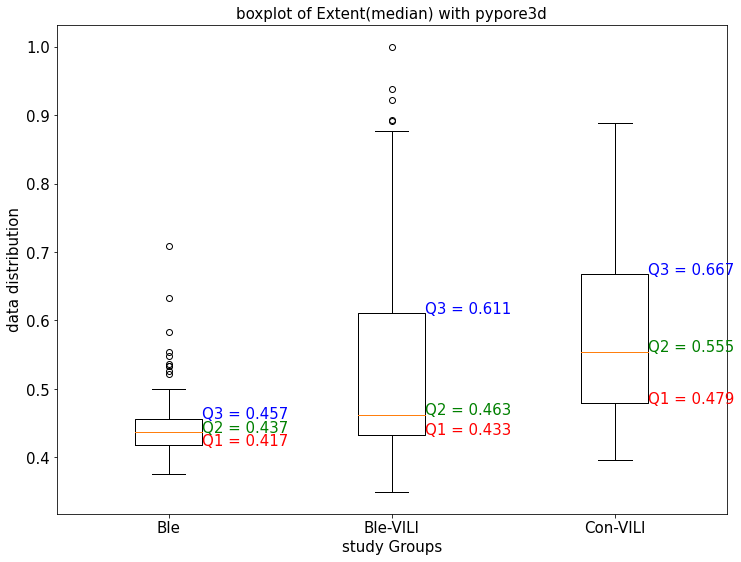

In [112]:
parameter_per_group = []
for key in scan_groups.keys():
    json_files = []
    for aFile in scan_groups[key]:
        fpath = os.path.join(root_dir, aFile, 'result')
        json_files += glob(fpath + '\*.json')

    parameter = []
    for json_file in json_files:
        file = open(json_file)
        data = json.load(file)
        file.close()
        extract_feature = data['blob_analysis']['result']['EXTENT']

        #
        # do what we want to plot for exampe, blob volume
        #
        if len(extract_feature) > 0:
            # parameter += extract_feature
            parameter.append(np.median(extract_feature))
            # parameter.append(ratio_greater_than_threshold(extract_feature, 1000000))

    parameter_per_group.append([key, parameter]) 

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(12,9))

# Create the boxplot
bp = ax.boxplot([x[1] for x in parameter_per_group])

# Loop through the boxes and add the quartile values as text
for i, box in enumerate(bp['boxes']):
    # Calculate the quartiles
    q1, q2, q3 = np.percentile([x[1] for x in parameter_per_group][i], [25, 50, 75])
    

    # Add text labels for the quartile values
    ax.text(i+1.15, q1, f'Q1 = {q1:.3f}', color='r', fontsize=15)
    ax.text(i+1.15, q2, f'Q2 = {q2:.3f}', color='g', fontsize=15)
    ax.text(i+1.15, q3, f'Q3 = {q3:.3f}', color='b', fontsize=15)

# Add labels and a title to the plot
ax.set_xlabel('study Groups', size=15)
ax.set_ylabel('data distribution', size=15)
ax.set_title(('boxplot of Extent(median)' + ' with ' + 'pypore3d'), size=15)
ax.set_xticklabels([x[0] for x in parameter_per_group])
ax.tick_params(axis='both', which='major', labelsize=15)
# ax.set_ylim([-0.0000001, 0.000001])

# Display the plot
plt.show()